## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, several supervised algorithms are employed to accurately model individuals' income using data collected from the 1994 U.S. Census. The best candidate algorithm will be selected from preliminary results and then further optimization of this algorithm will be implemented to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The cell below will load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, the following will be computed:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [4]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = (data.income == '>50K').sum()

# Number of records where individual's income is at most $50,000
n_at_most_50k = (data.income == '<=50K').sum()

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Feature set Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

The code cell below plota a histogram of these two features. Note the range of the values present and how they are distributed.

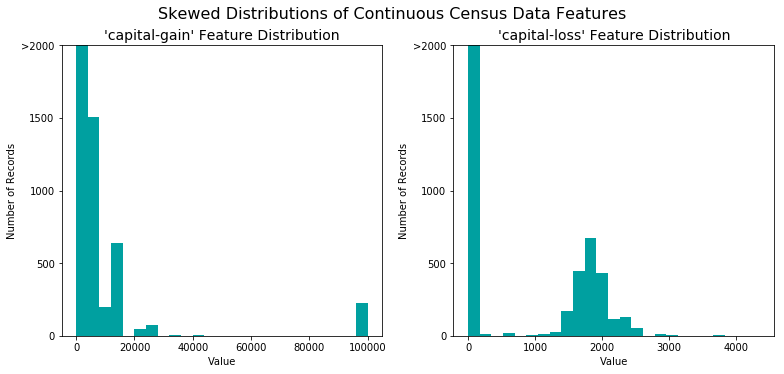

In [5]:
# Splitting the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

The code cell below will perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

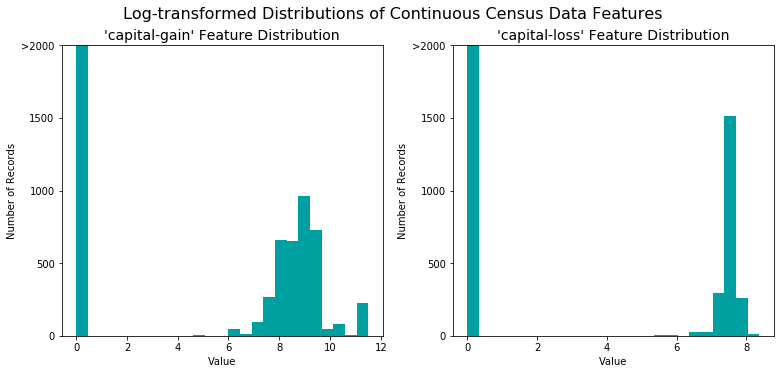

In [6]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

The code cell below will normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [7]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, the following will be implemented:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [8]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform, drop_first= True)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0 , '>50K' : 1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Print the encoded feature names
print(encoded)

95 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupa

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

The code cell below will perform this split.

In [9]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? In the code cell below, results are assigned to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.


* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [18]:

TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = (TP + TN) / income.shape[0]
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = ((1 + (0.5**2)) * precision * recall) / (((0.5**2) *  precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
Below is a list of three of the supervised learning models above that are appropriate for this problem that will be tested on the census data. For each model chosen I will:

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

1- Logistic Regression:
- Logistic Regression is one of the most popular classification machine learning algorithms out there. It is widely applied in medical industry when reaching a binary answer is needed, due to its ability to process huge amounts of data with high accuracy and speed. One medical application implemeted by a medical company working in the blood testing sector was trying to identify the possible relationships between specific genes and micro RNA.
- The strenghts of this model are usually speed and accuracy when trying to answer a simple yes or no question like:"does a connection between these two elements exist?". In addition, the work done by this algorthim is transparent and the reasons behind why a decision has been made can be identified.
- This model performs poorly when there is high non-linearity in the variables of the data given. In other words, Logistic regression is a high bias / low variance model, and if the data given had high variance then the logistic model is not going to perform very well.
- This model is a good candidate for this problem because it is a simple classification problem. As previously mentioned, logistic regression performs well in predicting binary answers in classification problems like this one where we are tyring to predict whether an individual makes more or less than 50K for income.
- references: https://activewizards.com/blog/5-real-world-examples-of-logistic-regression-application , https://www.statology.org/logistic-regression-real-life-examples/ , http://scott.fortmann-roe.com/docs/BiasVariance.html , http://scott.fortmann-roe.com/docs/BiasVariance.html

2- Gaussian Naive Bayes
- Among the most popular real world applications of this model is Spam detection which uses this model to detect if an email is spam or not and based on its evaluation, emails are filtered and those identified as spam are moved to spam folder. This is also means that it is very efficient and useful with classification problems, especially those where the variables are thought to be independant of one another. Google uses this model to classifiy webpages.
- A major strength of Gaussian NB model is its speed. It sure is fast that it is widely and commonly used in real time prediction. It also performs better than other models when the data set is small and only small training data is needed.
- This model's weakness is shown when dealing with data whose variables are very dependant and where complex classification is needed. Also, there is widely known weakness called "Zero frequency" which happens when the testing data contains a variable that wasn't present in the training data, the model then assigns zero to the probability of that new variable.
- This model is a fast classification model which exactly the problem at hand. It could be very helpful in determining which individuals belong to the "greather than 50K" category and which belong to the "less than 50K" category in an efficient manner.
- references: https://towardsdatascience.com/all-about-naive-bayes-8e13cef044cf , https://www.upgrad.com/blog/naive-bayes-classifier/ , https://www.quora.com/In-what-real-world-applications-is-Naive-Bayes-classifier-used

3- Ensemble Methods
- This model is applied in real world to many problems including fraud detecion, finger print identification and MRI classifcation. Focusing on fraud detection, this model can identify whether a transaction is fraud or not based on data provided using multiple methods including Bagging, AdaBoosting and Random Forests.
- Ensemble methods usually yield better results that is more improved than what a single model can produce, and this is primarily because it combines and averages the results of muliple models to create a more refined prediction.
- One weakness of this model is that it could be difficult to interpret which makes it difficult to present and explain results. Also, if the variance in prediction errors made by the contributing models is high, the model could perfrom poorly.
- This model could be a good opportunity to generate a refined prediction for our problem. Using combined results from multiple models, we may be able to improve the prediction results for determining if an individual earns more than 50K of income or not.
- reference: https://www.researchgate.net/publication/222425707_Classifier_ensembles_Select_real-world_applications , https://www.toptal.com/machine-learning/ensemble-methods-machine-learning, https://machinelearningmastery.com/why-use-ensemble-learning/ , https://blogs.perficient.com/2019/11/07/predictive-model-ensembles-pros-and-cons/ , https://www.quora.com/Can-you-give-some-specific-examples-of-Ensemble-Learning


### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model chosen, it's important to create a training and predicting pipeline that  quickly and effectively train models using various sizes of training data and perform predictions on the testing data.
In the code block below, the following is implemented:

In [54]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score , accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(X_train,y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test), then get predictions on the first 300 training samples(X_train)
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = np.sum(predictions_train == y_train[:300])/len(y_train[:300])
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation
In the code cell, the following will be implemented:
- Import the three supervised learning models discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - Use the default settings for each model — will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
GaussianNB trained on 362 samples.
GaussianNB trained on 3618 samples.
GaussianNB trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.


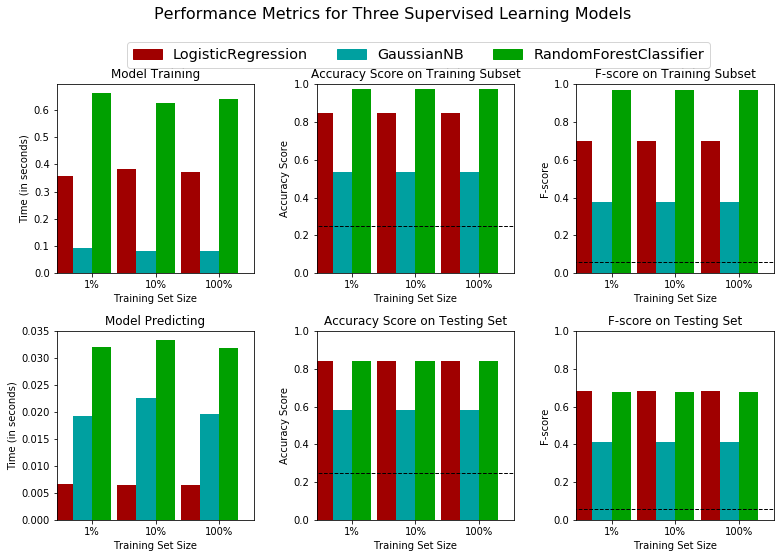

In [57]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
# Initialize the three models
clf_A = LogisticRegression(random_state= 42)
clf_B = GaussianNB()
clf_C = RandomForestClassifier(random_state= 42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = round(samples_100 * 0.1)
samples_1 = round(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, from the three supervised learning models the *best* model will be used on data. Then a grid search optimization for the model will be performed over the entire training set (`X_train` and `y_train`) by tuning parameters to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation performed earlier, below is an explanation for *CharityML* clarifying which of the three models is believed to be most appropriate for the task of identifying individuals that make more than \$50,000. 

The F score for the testing set when 100% of the training set is used will be checked. The answer will include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

Based on the evaluation of the three models above it makes sense to choose **Logistic Regression** as our best model, and here is the explaination why:

- It is very clear that the GaussianNB model is most poorly performing model from the three selected models. That most likely is because the variables of our data are not independant as the GaussianNB model require to perform well, therefore it is immediatly discarded. The choice now is between the Logistic Regression model and the Random Forest Model. Even though the Random forest model was able to produce better results than the Logistic model in terms of accuracy and fscore for the Model Training, the Logistic Regression model was able to produce similar to that produced by the Random Forest model for the Testing Model, at all sample sizes.
- The Logistic Regression Model had very clear edge in terms of speed over the other two models, and especially over the Random Forest model which is the model that it competes with in terms of prediction accuracy and fscore. The Logistic Regression models was able to produce the prediction results quality as well as the same accuracy and fscores a the Random Forest model at least 5 times faster than the Random Forest model (approx. 0.006 seconds and 0.032 seconds respectively), which motivates us to select the Logistic Regression model due to its speed, accuracy and simplicity.
- Logistic Regression is perfectly suitable for this data as it represents a classification problem with multiple variables. The Random Forest model though can still produce the same results quality but is much slower, that is mainly because Logistic Regression is a much simpler model that can generalize well over data that is linear and yield binary results.

### Question 4 - Describing the Model in Layman's Terms

* Explaining to *CharityML*, in layman's terms, how the final model chosen is supposed to work, describing the major qualities of the model, such as how the model is trained and how the model makes a prediction and avoiding using advanced mathematical jargon, such as describing equations.

Our Logistic Regression model simply predicts if a certain entry is belongs to a certain category or not through calculating probabilities from previously known labeled data. Its output can only be 0 or 1, 0 respresents a no and 1 represents a yes as the answer for our question, which in our case is: does this person make more than 50K income? 

The model looks at the data provided for training and gradually tries to find a line or that best separates all points that earn 50K or more from those who earn less. Then whenever a new point is entered, the model looks at its position relative to that line and based on that position it determines which category that new points is likely to belong to. Alternatively, this could be explained by saying, our model calculates the probability a certain individual makes 50K or more based on the variabes in our training data, then when a new individual is being considered, it calculates that probability that new individual belongs to the 50K or more category based on the information it already knows from the triaingin model, and if that probabilty exceeds a certain threshold, that individual will be assigned to the 50K or more category, and if not, he will be assigned to the other group.

references: https://www.analyticsvidhya.com/blog/2021/07/an-introduction-to-logistic-regression/#:~:text=Logistic%20Regression%20is%20a%20%E2%80%9CSupervised,used%20for%20Binary%20classification%20problems , http://www.sthda.com/english/articles/36-classification-methods-essentials/151-logistic-regression-essentials-in-r/ , https://machinelearningmastery.com/logistic-regression-for-machine-learning/

### Model Tuning
Fine tuning the chosen model using grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values, using the entire training set. In the code cell below, the following will be implemented:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
- Example: `parameters = {'parameter' : [list of values]}`.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [58]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [66]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = LogisticRegression(random_state= 42)

# Create the parameters list to tune, using a dictionary if needed.
parameters = {'C':[0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.5, 1 , 2, 3], 'max_iter': list(range(100,1000,100)), 
              'penalty': ['l1','l2']}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
Final accuracy score on the testing data: 0.8423
Final F-score on the testing data: 0.6845


### Question 5 - Final Model Evaluation

* What is the optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from the optimized model compare to the naive predictor benchmarks found earlier in **Question 1**?_  

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8419       |     0.8423      |
| F-score        |      0.6832       |     0.6845      |


- The optimized model accuracy is 84.23% which is 0.04% better than the unoptimized model, and the fscore for the optimized model is 68.45% which is 0.19% better thab the unoptimized model. 
- The scores of the optimized model are in general better than the unoptimized model, however, the improvement is very small that it can be neglected especially if th optimized model is going to take much longer time to make predictions.
- The Naive Predictor model had an Accuracy score of 0.2478 and F-score of 0.2917, which when compared to our new models' results inidcates that we have managed to build a much better performing model using Logistic Regression and Grid Search.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

A scikit-learn classifier will be chosen (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell this classifier will be fitted to training set and this attribute will be used to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features would initially be believed to have most importance for prediction, and in what order would they be ranked and why?

Before intial analysis, I think from all of the features on record in the census data, the most important would be: Capital gain, Age, Education level, Hours per week and Marraige status, in that order. The reasons for that is:
- Capital gain is an important indicator for if an individual has money to spare  or not
- The older the individual, the more likely he or she has better income or savings
- Education level is correlated to an individual's ability to work better jobs and earn higher income, as well as is an indicator of awareness and comprehension of the issue that requires donation
- Hours per week again indicates if a person works enough to generate the income level required
- Marraige status can be correlated with the amount of financial responsability an individual has, hence, single and widowed individuals for example may have less financial obligations which will allow that individual to make more investments and earn more income

### Extracting Feature Importance
In the code cell below, the following will be implemented:
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

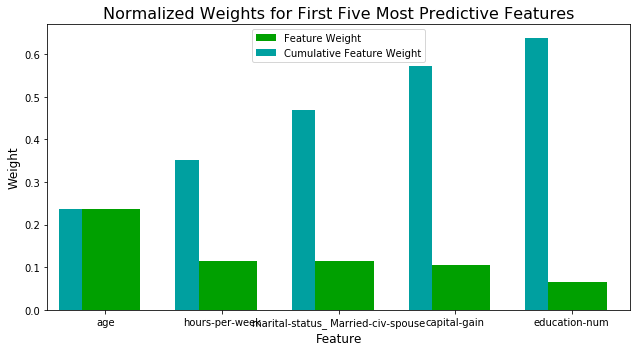

In [67]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If previous answer was close to the same answer, how does this visualization confirm the initial thoughts? 
* If it were not close, why are these features more relevant?

- The five features from the visualization above are almost identical to the ones i presented in question 6, but the order is not the same, which is totally understandable.
- The results confirm my understanding of the factors that may contribute for predicting if an individual earns more or less than 50K for income, however, there is a chance that these features may be imprtant for different reasons too. In all ways, extended research would be required to identify if these features are import for the reasons mentioned and/or entirely different reasons.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model found earlier, and train it on the same training set *with only the top five important features*. 

In [68]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8423
F-score on testing data: 0.6845

Final Model trained on reduced data
------
Accuracy on testing data: 0.8269
F-score on testing data: 0.6487


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, should using the reduced data as the training set be considered?

- The accuracy score of the final model trained on reduced data is 82.69% , which is only 1.54% worse that the final model trained on full data. Also, The fscore score of the final model trained on reduced data is 64.87% , which is 3.58% worse that the final model trained on full data. Since precision is our preference for this model, 3.58% of our data set is approx. 1619 individual, which is enough to pursuade me to discard adopting the model trained on reduced data, in normal circumstances.
- If training time was a factor however, the model trained on reduced data is signficantly faster, and this case I would consider using the reduced data as the training data set, but still may end up deciding against it and would resort to retune the model parameters to produce better results than the that from the model trained on reduced data set but at much faster time frame than the it did one the orginal model trained on full data.

**Project by: Mahmoud Mohsen**